In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")
clr.AddReference(r"..\bin\MiniSim.FlowsheetDrawing")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes
from  MiniSim.Core.Flowsheeting.Documentation import SpreadsheetElement
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection, BlackBoxReactor
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem
from MiniSim.FlowsheetDrawing import FlowsheetDrawer, DrawingOptions

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image as render
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

In [5]:
def calc(flowsheet, relax, maxIter):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    presolver.Solve(flowsheet)
    print (logger.Flush())
    
def decomp(flowsheet):
    solver= num.DecompositionSolver(logger)
    status=solver.Solve(flowsheet)
    print (logger.Flush())
    return status
    
def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 

In [6]:
sys= ThermodynamicSystem("Test2","NRTL", "default")
			
sys.AddComponent(Database.FindComponent("Benzene").RenameID("BENZENE"))
sys.AddComponent(Database.FindComponent("Propylene").RenameID("PROPYLEN"))
sys.AddComponent(Database.FindComponent("Propane").RenameID("PROPANE"))
sys.AddComponent(Database.FindComponent("Cumene").RenameID("CUMOL"))
sys.AddComponent(Database.FindComponent("P-diisopropylbenzene").RenameID("DIPB"))
Database.FillBIPs(sys)
sys.VariableFactory.SetTemperatureLimits(253,850)

kmolh=Unit.Make([SI.kmol],[SI.h])
cumh=Unit.Make([SI.cum],[SI.h])
kJmol=Unit.Make([SI.kJ],[SI.mol])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.SpecificMolarEnthalpy, kJmol)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MolarFlow, kmolh)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.VolumeFlow, cumh)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Temperature, METRIC.C)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.kW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFraction, METRIC.weightpercent)
reporter.Report(sys)
print(logger.Flush())


Report for thermodynamic system Test2

Equilibrium

VLEQ Method      : GammaPhi
Activity Method  : NRTL
Fugacity Method  : Ideal
Henry Method     : False

Unit of Measure

Dimension                 Input           Output         
Dimensionless                                            
Temperature               K               °C             
Pressure                  Pa              bar            
Mass                      kg              kg             
Mole                      mol             mol            
Length                    m               m              
Area                      sqm             sqm            
Volume                    cum             cum            
MassFlow                  kg/s            t/h            
MolarFlow                 mol/s           kmol/h         
HeatFlow                  J/s             kW             
Enthalpy                  J/s             kW             
VolumeFlow                cum/s           cum/h          
MolarWeight    

In [7]:
S01 = MaterialStream("S01", sys)		\
		.Specify("T",25, METRIC.C)		\
		.Specify("P",25, METRIC.bar)		\
		.Specify("n",104.2, kmolh)\
		.Specify("x[BENZENE]",1)		\
		.Specify("x[PROPYLEN]",0)		\
		.Specify("x[PROPANE]",0)		\
		.Specify("x[CUMOL]",0)			\
		.Init("x[DIPB]",0)\
		.InitializeFromMolarFractions()\
		.FlashPT()

S02 = MaterialStream("S02", sys)

S03 = MaterialStream("S03", sys)\
		.Specify("T",26, METRIC.C)\
		.Specify("P",25, METRIC.bar)\
		.Specify("n",110, kmolh)\
		.Specify("x[BENZENE]",0.0)\
		.Init("x[PROPYLEN]",0.95)\
		.Specify("x[PROPANE]",0.05)\
		.Specify("x[CUMOL]",0)\
		.Specify("x[DIPB]",0)\
		.InitializeFromMolarFractions()\
		.FlashPT()

S04 = MaterialStream("S04", sys)
S05 = MaterialStream("S05", sys)
S06 = MaterialStream("S06", sys)
S07 = MaterialStream("S07", sys)
S08 = MaterialStream("S08", sys)
S09 = MaterialStream("S09", sys)
S10 = MaterialStream("S10", sys)
S11 = MaterialStream("S11", sys)
S12 = MaterialStream("S12", sys)

S13 = MaterialStream("S13", sys)		\
		.Specify("T",60, METRIC.C)		\
		.Specify("P",1.75, METRIC.bar)		\
		.Specify("n",102.4, kmolh)\
		.Init("x[BENZENE]",0.956)		\
		.Specify("x[PROPYLEN]",0.02)		\
		.Specify("x[PROPANE]",0.024)		\
		.Specify("x[CUMOL]",0)			\
		.Specify("x[DIPB]",0)\
		.InitializeFromMolarFractions()\
		.FlashPT()

S14 = MaterialStream("S14", sys)

MIX01 = Mixer("MIX01",sys)\
		.Connect("In", S01)\
		.Connect("In", S13)\
		.Connect("Out", S02)\
		.Specify("P", 25, METRIC.bar)
		
MIX01.GetVariable("DP").LowerBound=-1e9
MIX01.Initialize()
MIX01.Solve()

MIX02 = Mixer("MIX02",sys)\
		.Connect("In", S02)\
		.Connect("In", S03)\
		.Connect("Out", S04)\
		.Specify("DP",0,METRIC.bar)\
		.Initialize()\
		.Solve()
		
HEAT01 = Heater("HEAT01",sys)\
		.Connect("In", S04) \
		.Connect("Out", S05) \
		.Specify("DP",0, METRIC.mbar)\
		.Specify("T",209, METRIC.C)\
		.Initialize()\
		.Solve()


HEX01 = Heater("HEX01",sys)\
		.Connect("In", S05)\
		.Connect("Out", S06)\
		.Specify("DP",0, METRIC.mbar)\
		.Specify("T",300, METRIC.C)\
		.Initialize()\
		.Solve()

HEAT02 = Heater("HEAT02",sys)\
		.Connect("In", S06) \
		.Connect("Out", S07) \
		.Specify("DP",0, METRIC.mbar)\
		.Specify("T",360, METRIC.C)\
		.Initialize()\
		.Solve()

REAC01 = BlackBoxReactor("REAC01",sys, 2)\
		.Connect("In", S07)\
		.Connect("Out", S08)\
		.AddStochiometry(1, "PROPYLEN", -1.0)\
		.AddStochiometry(1, "BENZENE", -1.0)\
		.AddStochiometry(1, "CUMOL", 1.0)\
		.AddStochiometry(2, "PROPYLEN", -1.0)\
		.AddStochiometry(2, "CUMOL", -1.0)\
		.AddStochiometry(2, "DIPB", 1.0)\
		.Specify("T", 427, METRIC.C)\
		.Specify("P", 25, METRIC.bar)
		
V=expr.Variable("V",1.0)
T=REAC01.GetVariable("T")
CPROP=S08.GetVariable("x[PROPYLEN]")
CBENZ=S08.GetVariable("x[BENZENE]")
CCUM=S08.GetVariable("x[CUMOL]")

parser= expr.SymbolicExpressionParser()
parser.RegisterVariable(V)
parser.RegisterVariable(T)
parser.RegisterVariable("CPROP",CPROP)
parser.RegisterVariable("CBENZ",CBENZ)
parser.RegisterVariable("CCUM",CCUM)

REAC01.DefineRateEquation(1,   parser.ParseExpression("V*1000*28000000*exp(-104174/(8.31415*T))*CPROP*CBENZ"))\
		.DefineRateEquation(2, parser.ParseExpression("V*1000*2320000000*exp(-146742/(8.31415*T))*CPROP*CCUM"))\
		.Initialize()\


flowsheet= Flowsheet("Flow")\
		.AddMaterialStreams(S01, S02, S03, S04,S05, S06,S07,S08,S13)\
		.AddUnits(MIX01, MIX02, HEAT01, HEX01,HEAT02,REAC01)

In [8]:
decomp(flowsheet)

Decomposition Result: V=325, E=325, Blocks=226, Singletons=216
Block Statistics:
   # Var # Blocks % Blocks
       1      216  95,58 %
       8        1   0,44 %
      11        7   3,10 %
      12        2   0,88 %
Problem NLAES was successfully solved (0,03 seconds)



True

In [9]:
'''
S13d= MaterialStream("S13d",sys)
S13d.CopyFrom(S13)

subflow = ColumnBuilder2("COL1",sys, S12, S13d, S14, 15,8, 60, 1.75,0.7)
COL1= 	subflow.GetUnit("COL1_SEC01")
REFSPLI1= 	subflow.GetUnit("COL1_REFSPLI")
REB1= 		subflow.GetUnit("COL1_REB")
COND1= 		subflow.GetUnit("COL1_COND")

COL1.Name="COL1"
REFSPLI1.Name="REFSPLI1"
REB1.Name="REB1"
COND1.Name="COND1"


flowsheet.Merge(subflow)
decomp(flowsheet)


printTitle('ADDING COLUMN 2')
		
S15= MaterialStream("S15",sys)
S16= MaterialStream("S16",sys)

subflow = ColumnBuilder2("COL2",sys, S14, S15, S16, 20,12, 110, 1.0,0.75)
COL2= 	subflow.GetUnit("COL2_SEC01")
REFSPLI2= 	subflow.GetUnit("COL2_REFSPLI")
REB2= 		subflow.GetUnit("COL2_REB")
COND2= 		subflow.GetUnit("COL2_COND")

COL2.Name="COL2"
REFSPLI2.Name="REFSPLI2"
REB2.Name="REB2"
COND2.Name="COND2"


flowsheet.Merge(subflow)
decomp(flowsheet)
'''
 

'\nS13d= MaterialStream("S13d",sys)\nS13d.CopyFrom(S13)\n\nsubflow = ColumnBuilder2("COL1",sys, S12, S13d, S14, 15,8, 60, 1.75,0.7)\nCOL1= \tsubflow.GetUnit("COL1_SEC01")\nREFSPLI1= \tsubflow.GetUnit("COL1_REFSPLI")\nREB1= \t\tsubflow.GetUnit("COL1_REB")\nCOND1= \t\tsubflow.GetUnit("COL1_COND")\n\nCOL1.Name="COL1"\nREFSPLI1.Name="REFSPLI1"\nREB1.Name="REB1"\nCOND1.Name="COND1"\n\n\nflowsheet.Merge(subflow)\ndecomp(flowsheet)\n\n\nprintTitle(\'ADDING COLUMN 2\')\n\t\t\nS15= MaterialStream("S15",sys)\nS16= MaterialStream("S16",sys)\n\nsubflow = ColumnBuilder2("COL2",sys, S14, S15, S16, 20,12, 110, 1.0,0.75)\nCOL2= \tsubflow.GetUnit("COL2_SEC01")\nREFSPLI2= \tsubflow.GetUnit("COL2_REFSPLI")\nREB2= \t\tsubflow.GetUnit("COL2_REB")\nCOND2= \t\tsubflow.GetUnit("COL2_COND")\n\nCOL2.Name="COL2"\nREFSPLI2.Name="REFSPLI2"\nREB2.Name="REB2"\nCOND2.Name="COND2"\n\n\nflowsheet.Merge(subflow)\ndecomp(flowsheet)\n'

# Report Mass Balance Results

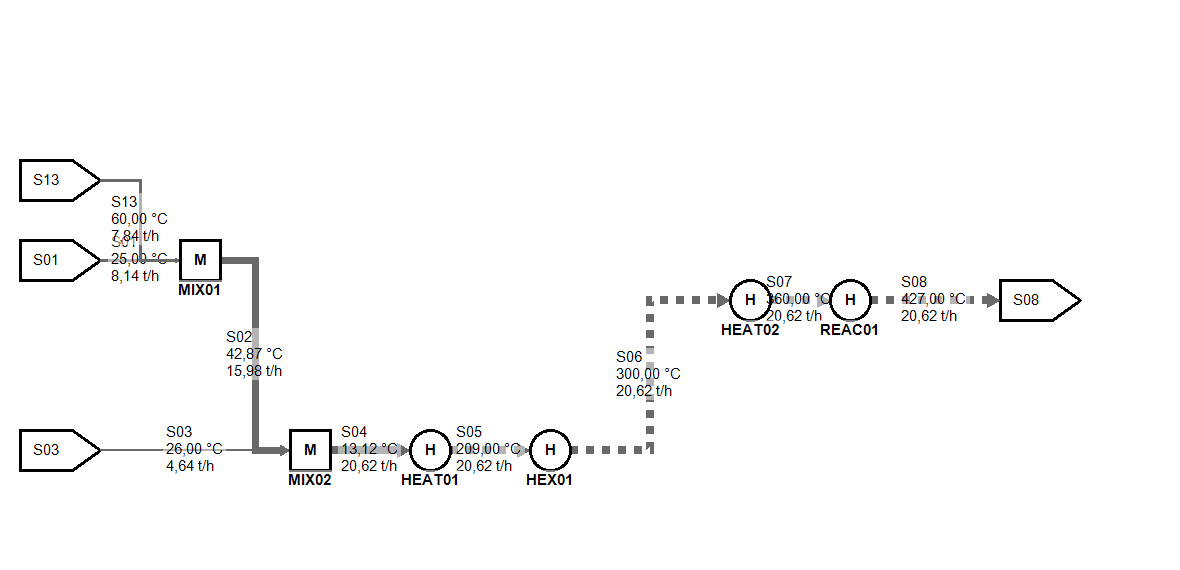

In [10]:
MIX01.SetIcon(IconTypes.Mixer, 180,240)
MIX02.SetIcon(IconTypes.Mixer, 290,430)
HEAT01.SetIcon(IconTypes.Heater, 410,430)
HEX01.SetIcon(IconTypes.Heater, 530,430)
HEAT02.SetIcon(IconTypes.Heater, 730,280)
#HEAT03.SetIcon(IconTypes.Heater, 620,590)
#FLASH01.SetIcon(IconTypes.TwoPhaseFlash, 840,590)
REAC01.SetIcon(IconTypes.Heater, 830,280).SetColors("OrangeRed","White")
#COL1.SetIcon(IconTypes.ColumnSection, 980,510)
#COND1.SetIcon(IconTypes.Heater, 1080,370)
#REFSPLI1.SetIcon(IconTypes.Splitter, 1200,370)
#REB1.SetIcon(IconTypes.TwoPhaseFlash, 1110,880)
#COL2.SetIcon(IconTypes.ColumnSection, 1370,710)
#COND2.SetIcon(IconTypes.Heater, 1480,590)
#REFSPLI2.SetIcon(IconTypes.Splitter, 1610,590)
#REB2.SetIcon(IconTypes.TwoPhaseFlash, 1550,1060)
#RECY01.SetIcon(IconTypes.Breaker, 1280,290)
S01.SetIcon(IconTypes.Stream, 20,240)
S03.SetIcon(IconTypes.Stream, 20,430)

S08.SetIcon(IconTypes.Stream, 1000,280)
S13.SetIcon(IconTypes.Stream, 20,160)

#S15.SetIcon(IconTypes.Stream, 1850,500)
#S16.SetIcon(IconTypes.Stream, 1850,1140)

flowsheet.Name="Cumene Process (Luyben)"

options=DrawingOptions()
options.ShowStreamWidth=True
options.ShowPressure=False
options.ShowTemperature=True
options.ShowStreamColors=False
render(convertFlowsheet(flowsheet,options))